## Cluster-Mass based Permutation testing in Julia

- Step 1: load and check adjacency matrix
- Step 2: generate simuated data
- Step 3: run cluster-mass permutation test

### Load Libraries

In [23]:
import Pkg
#Pkg.activate("/data/p_02865/tools/UnfoldStats.jl/docs")
Pkg.activate("../ClusterComputation")
#Pkg.instantiate()


using UnfoldSim
using MAT 
using CairoMakie
using Random
using Statistics
using UnfoldMixedModels
#using UnfoldStats
using DataFrames
using MixedModelsPermutations
using UnfoldMakie
using Logging

include("../read_adjacency.jl")
include("../cluster_mass_test.jl") 


  Activating project at `~/Desktop/Code/ClusterComputation`
Precompiling packages...
 515836.9 ms  ✓ MakieThemes
  1 dependency successfully precompiled in 541 seconds. 481 already precompiled.


read_fieldtrip_neighbors

In [7]:
# load Hartmut head model
# needed for visualization of adjacency and simulation of effects
hart = Hartmut()

#Define 10-20 channels (these fit to the biosemi neighbours file we later use)
standard_1020 = ["Fp1", "AF3", "F7", "F3", "FC1", "FC5", "T7", "C3", "CP1", "CP5", "P7", "P3", "Pz", "PO3", "O1", "Oz", "O2", "PO4", "P4", "P8", "CP6", "CP2", "C4", "T8", "FC6", "FC2", "F4", "F8", "AF4", "Fp2", "Fz", "Cz"]


Please cite: HArtMuT: Harmening Nils, Klug Marius, Gramann Klaus and Miklody Daniel - 10.1088/1741-2552/aca8ce


32-element Vector{String}:
 "Fp1"
 "AF3"
 "F7"
 "F3"
 "FC1"
 "FC5"
 "T7"
 "C3"
 "CP1"
 "CP5"
 ⋮
 "T8"
 "FC6"
 "FC2"
 "F4"
 "F8"
 "AF4"
 "Fp2"
 "Fz"
 "Cz"

In [8]:
# Load FieldTrip neighbor file and reorder to match our channel layout - note that adjacency matrix might need to be created based on the individual set of channels (using MNE/Fieldtrip)
ft_neighbor_path = "/data/u_steinfath_software/Matlab_tooloxes/fieldtrip-20230118/template/neighbours/biosemi32_neighb.mat"

adjacency, matched_labels = read_fieldtrip_neighbors(
    ft_neighbor_path; 
    channel_order = standard_1020  # Reorder to match layout (should not matter in this example, since we use all channels)
)


(Bool[0 1 … 0 0; 1 0 … 1 0; … ; 0 1 … 0 1; 0 0 … 1 0], ["Fp1", "AF3", "F7", "F3", "FC1", "FC5", "T7", "C3", "CP1", "CP5"  …  "C4", "T8", "FC6", "FC2", "F4", "F8", "AF4", "Fp2", "Fz", "Cz"])

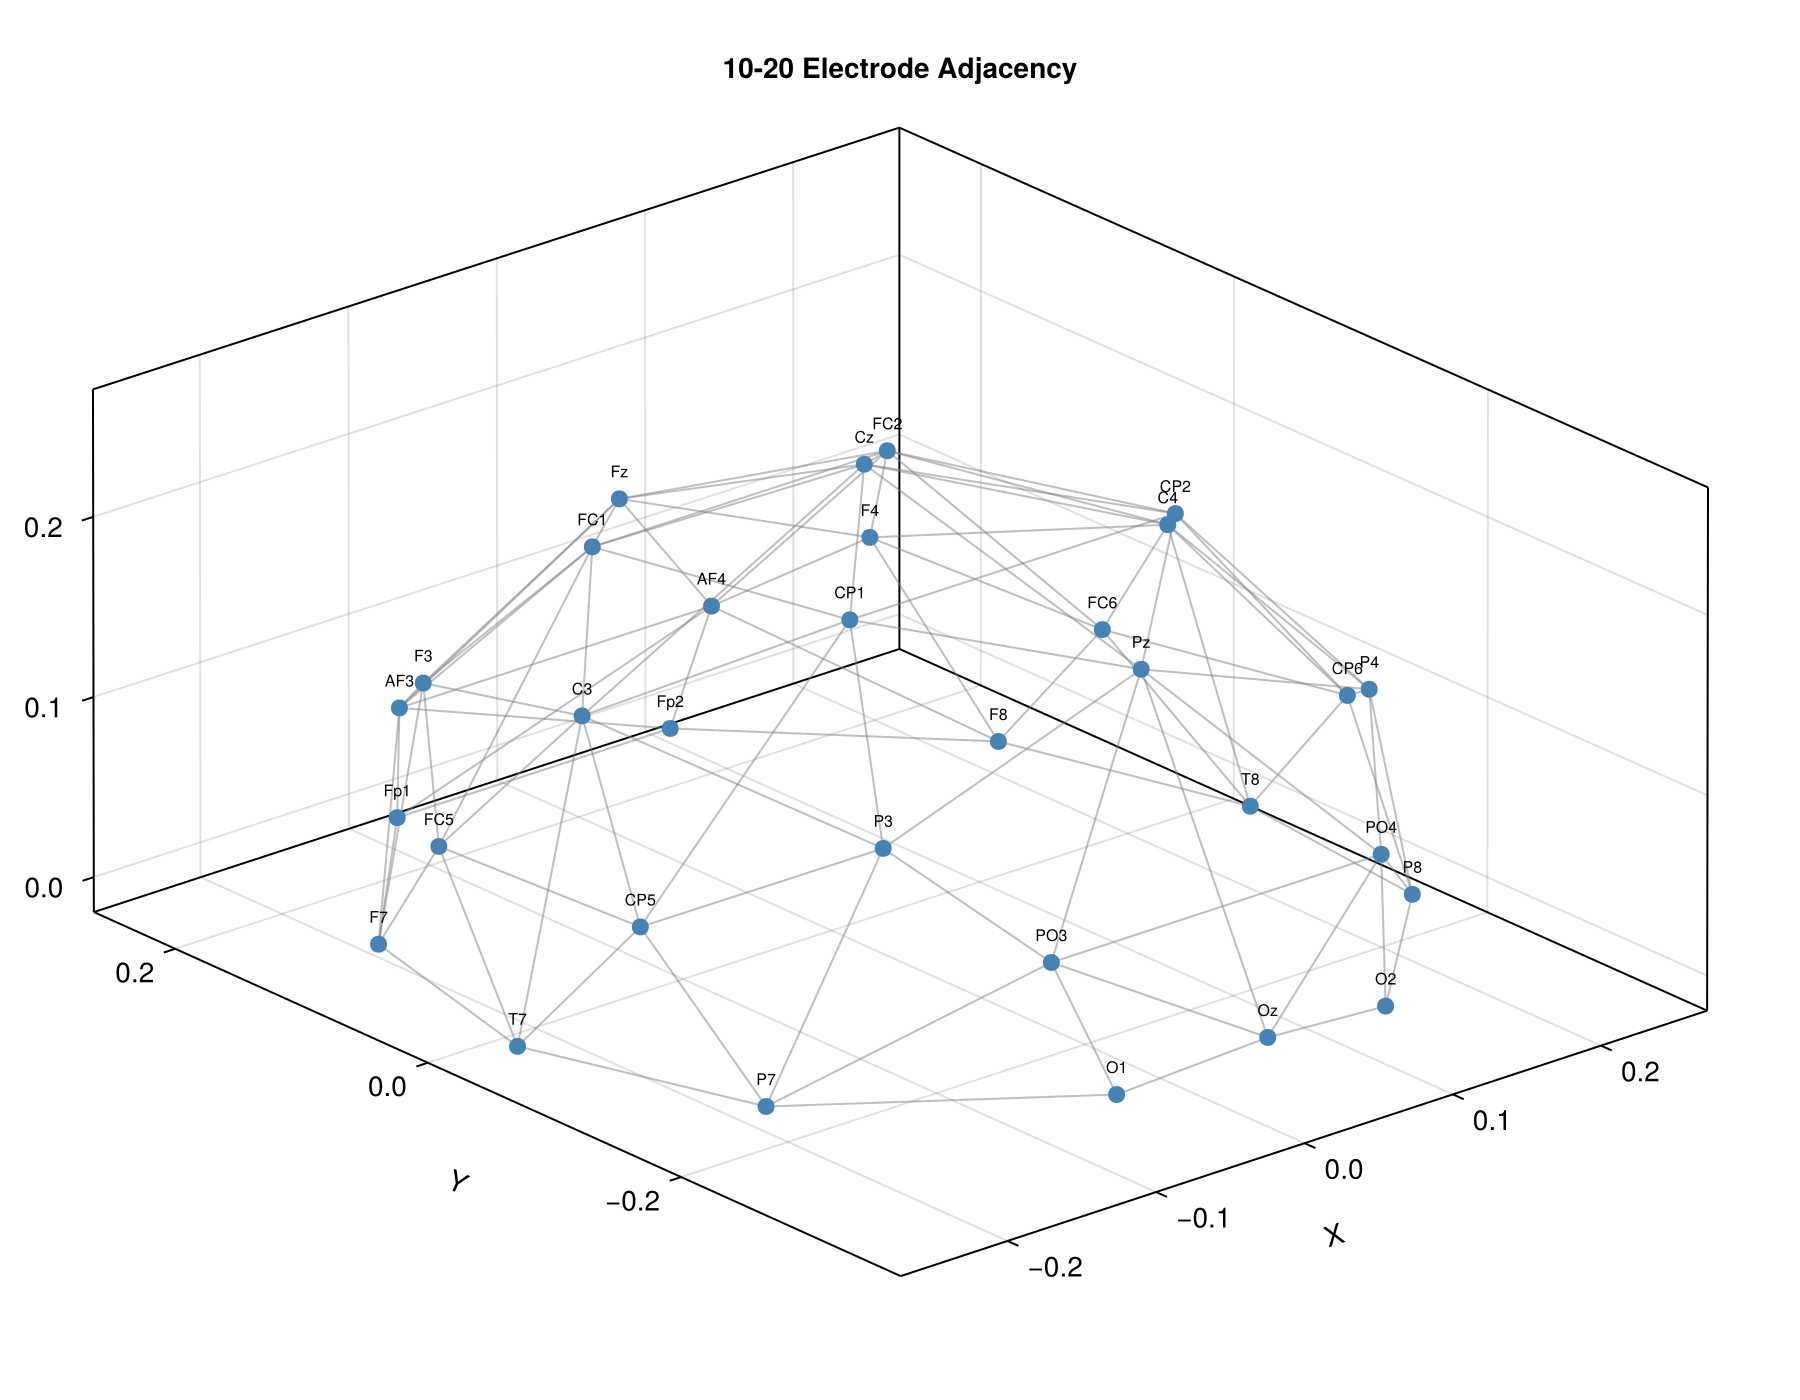

In [9]:
# Visualize the adjacency

# Find indices of channels in HArtMuT
all_labels = hart.electrodes["label"]
channel_idx_raw = [findfirst(==(ch), all_labels) for ch in standard_1020]

# Filter out channels not found in HArtMuT and get their labels
found_mask = .!isnothing.(channel_idx_raw)
channel_idx = Int64[idx for idx in channel_idx_raw if !isnothing(idx)]
electrode_labels = standard_1020[found_mask]

# Extract subset of electrode positions
electrode_positions = hart.electrodes["pos"][channel_idx, :]

fig = Figure(size = (900, 700))
ax = Axis3(fig[1, 1], 
    title = "10-20 Electrode Adjacency",
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    aspect = :data)

pos3d = electrode_positions

# Draw connections between adjacent electrodes
for i in 1:size(adjacency, 1)
    for j in (i+1):size(adjacency, 2)
        if adjacency[i, j]
            lines!(ax, 
                [pos3d[i, 1], pos3d[j, 1]], 
                [pos3d[i, 2], pos3d[j, 2]], 
                [pos3d[i, 3], pos3d[j, 3]],
                color = (:gray, 0.5), linewidth = 1.0)
        end
    end
end

# Draw electrode points with labels
scatter!(ax, pos3d[:, 1], pos3d[:, 2], pos3d[:, 3], 
    markersize = 12, color = :steelblue)

# Add electrode labels
for (i, label) in enumerate(electrode_labels)
    text!(ax, pos3d[i, 1], pos3d[i, 2], pos3d[i, 3] + 0.01, 
        text = label, fontsize = 8, align = (:center, :bottom))
end

fig

## 2. Simulate EEG data
- **15 subjects** with random effects (between subject variability)
- **30 items** with random effects (between item variability)
- **Face vs. Car** condition with a simulated effect at the N170 component

In [10]:
# Simulation parameters
sfreq = 50  # sampling frequency (Hz)
n_subjects = 15
n_items = 30 # per condition

# Experimental design: face vs cara
exp_design = MultiSubjectDesign(;
    n_subjects = n_subjects,
    n_items = n_items,
    items_between = Dict(:stimtype => ["car", "face"]),
)

contrasts = Dict(:stimtype => DummyCoding())

print(exp_design)


MultiSubjectDesign
  n_subjects: Int64 15
  n_items: Int64 30
  subjects_between: Dict{Symbol, Vector}
  items_between: Dict{Symbol, Vector}
  both_within: Dict{Symbol, Vector}
  event_order_function: #17 (function of type UnfoldSim.var"#17#18")


In [11]:
# Define ERP component
# P100 - no condition effect
p1 = MixedModelComponent(;
    basis = UnfoldSim.p100(; sfreq = sfreq), # positive peak at 100ms
    formula = @formula(dv ~ 1 + (1 | subject) + (1 | item)), # dv ~ 1 : fixed intecept (aka mean amplitude); (1|subject) random effect of subject (each subject has own offset); (1|item) random effect of item (each item has own offset)
    β = [5.0], #mean amplitude of 5 µV
    σs = Dict(:subject => [1.0], :item => [0.5]), #standard deviation of ranomd effects. 1 µV between subjects, 0.5 µV between items
    contrasts = contrasts, # encoding of categorical variables -> but anyhow no effect here
);

# N170 - WITH condition effect (faces more negative than cars)
# This is the effect we want to detect!
n1 = MixedModelComponent(;
    basis = UnfoldSim.n170(; sfreq = sfreq),
    formula = @formula(dv ~ 1 + stimtype + (1 + stimtype | subject) + (1 | item)), # this time we also have categorical predictor for stimulus type (faces vs cars.);(1 + stimtype | subject) means that each subject can have their own effect size for the stimtype effect ; (1 | item) means random intercept per item
    β = [1.0, 3],  # 1 is baseline amplitude for cars (intercept), and 5 is the additional effect of faces
    σs = Dict(:subject => [1.5, 0.3], :item => [0.5]), #standard deviation of ranomd effects. 1.5 µV between subjects for intercept, 0.3 µV between subjects for stimtype effect, 0.5 µV between items
    contrasts = contrasts, # encoding of categorical variables using dummy coding
);

# P300 - no condition effect
p3 = MixedModelComponent(;
    basis = UnfoldSim.p300(; sfreq = sfreq),
    formula = @formula(dv ~ 1 + (1 | subject) + (1 | item)),
    β = [4.0],
    σs = Dict(:subject => [1.0], :item => [0.5]),
    contrasts = contrasts,
);

In [12]:
# Project components to scalp using HArtMuT source locations
# We use realistic brain sources for each ERP component
mc_p1 = MultichannelComponent(p1, hart => "Right Occipital Pole")
mc_n1 = MultichannelComponent(n1, hart => "Left Occipital Fusiform Gyrus")  # N170 source
mc_p3 = MultichannelComponent(p3, hart => "Right Cingulate Gyrus, posterior division")

# Simulate the data (full HArtMuT 227 channels)
@time data_full, evts = UnfoldSim.simulate(
    MersenneTwister(42),
    exp_design,
    [mc_p1, mc_n1, mc_p3],
      # [mc_p3],
    UniformOnset(sfreq * 2, 10),
    PinkNoise(; noiselevel = 1.0);
    return_epoched = true,
)

# Handle 4D array: (channels, times, items, subjects) -> reshape to (channels, times, trials)
#227x12x60x30 -> 227x12x1800
n_ch_full, n_times_full, n_items_full, n_subjects_full = size(data_full)
data_full_3d = reshape(data_full, n_ch_full, n_times_full, n_items_full * n_subjects_full)

# Extract only the 10-20 channels we selected earlier
# 32x12x1800
data_e = data_full_3d[channel_idx, :, :]

n_channels = size(data_e, 1)
n_times = size(data_e, 2)
n_trials = size(data_e, 3)
times = range(-0.1, 0.5, length = n_times)

 33.839089 seconds (53.09 M allocations: 2.997 GiB, 9.90% gc time, 90.34% compilation time: 6% of which was recompilation)


-0.1:0.02857142857142857:0.5

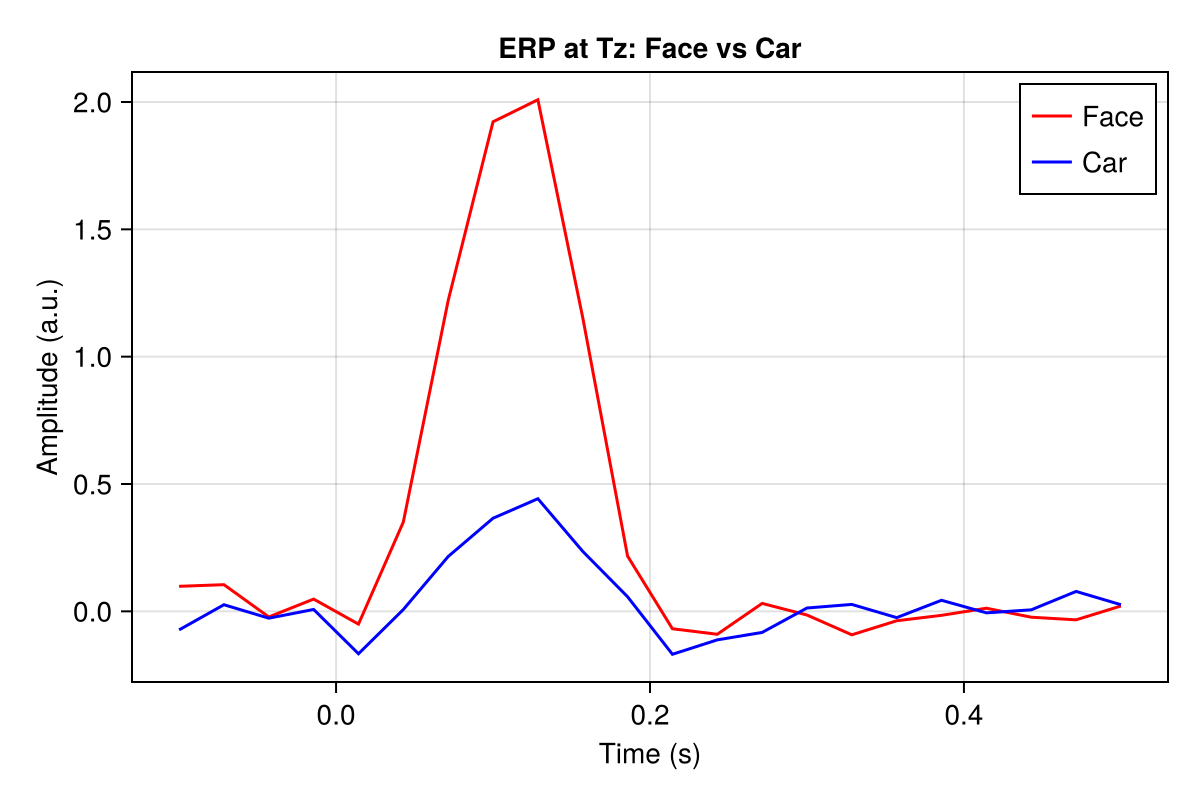

In [13]:
# Plot average ERP for faces vs cars at T7
pz_idx = findfirst(==("T7"), electrode_labels)

# Get trial indices for each condition
face_trials = findall(evts.stimtype .== "face")
car_trials = findall(evts.stimtype .== "car")

# Average across trials for each condition
erp_face = mean(data_e[pz_idx, :, face_trials]; dims=2)[:]
erp_car = mean(data_e[pz_idx, :, car_trials]; dims=2)[:]


# Plot
fig = Figure(size=(600,400))
ax = Axis(fig[1,1], xlabel="Time (s)", ylabel="Amplitude (a.u.)", title="ERP at Tz: Face vs Car")
lines!(ax, times, erp_face, color=:red, label="Face")
lines!(ax, times, erp_car, color=:blue, label="Car")
axislegend(ax)
fig

In [14]:
# Fit mass-univariate LMM
println("Fitting LMM at each channel × time point...")
@time m = fit(
    UnfoldModel,
    [
        Any => (
            @formula(0 ~ 1 + stimtype + (1 | item) + (1 | subject)),
            times,
        ),
    ],
    evts,
    data_e,
);

# OLD MODEL (commented out): @formula(0 ~ 1 + stimtype + (1 + stimtype | item) + (1 + stimtype | subject))
# This included random slopes for stimtype, which can cause singular fits and missing stderrors.


Fitting LMM at each channel × time point...


Progress:   0%|▏                                        |  ETA: 0:12:02┌ Warning: NLopt was roundoff limited
└ @ MixedModels /data/u_steinfath_software/.julia/packages/MixedModels/ZnFbm/src/nlopt.jl:114
┌ Warning: NLopt was roundoff limited
└ @ MixedModels /data/u_steinfath_software/.julia/packages/MixedModels/ZnFbm/src/nlopt.jl:114
┌ Warning: NLopt was roundoff limited
└ @ MixedModels /data/u_steinfath_software/.julia/packages/MixedModels/ZnFbm/src/nlopt.jl:114
┌ Warning: NLopt was roundoff limited
└ @ MixedModels /data/u_steinfath_software/.julia/packages/MixedModels/ZnFbm/src/nlopt.jl:114
┌ Warning: NLopt was roundoff limited
└ @ MixedModels /data/u_steinfath_software/.julia/packages/MixedModels/ZnFbm/src/nlopt.jl:114
┌ Warning: NLopt was roundoff limited
└ @ MixedModels /data/u_steinfath_software/.julia/packages/MixedModels/ZnFbm/src/nlopt.jl:114
┌ Warning: NLopt was roundoff limited
└ @ MixedModels /data/u_steinfath_software/.julia/packages/MixedModels/ZnFbm/src/nlopt.jl:114
┌ War

 12.202422 seconds (18.08 M allocations: 882.943 MiB, 3.34% gc time, 92.17% compilation time: 4% of which was recompilation)


Unfold-Type: ::UnfoldLinearMixedModel{{Float64}} 
  Any => 1 + stimtype + (1 | item) + (1 | subject) 
 
✔ model is fit.  size(coefs) (32, 22, 2) 
 
Useful functions: `design(uf)`, `designmatrix(uf)`, `coef(uf)`, `coeftable(uf)`

### 3. Perform cluster-mass permutation test

In [24]:
# --- Cluster-mass permutation test using explicit functions ---

coefficient = 2  # stimtype effect (face vs car)
n_permutations = 50  # Reduced for dev; use 500-1000 for real analyses
threshold = 2.0

time_selection = 1:length(times)

# 2. Generate permutation distribution
permuted = lmm_permutations(MersenneTwister(42), m, data_e, coefficient; 
    n_permutations = n_permutations,
    lmm_statistic = :z,
    time_selection = time_selection
)



32×22×50 Array{Float64, 3}:
[:, :, 1] =
 -1.51282    -1.71466    -1.76864    …   0.19076    -0.168483   -1.34852
 -0.0339084   0.209766   -1.66309       -1.05238     2.2358      0.680929
 -0.455484   -0.15827    -0.405532       0.531843   -0.599111   -0.85889
 -1.00525    -0.20559     0.354423       0.108536   -0.351409   -1.03106
 -0.232908   -0.611307    0.0811061      1.0353      0.920676   -0.987155
 -0.531376   -0.398169   -1.62583    …   0.331899    0.73631    -0.581616
 -0.353151   -2.02984    -1.1742         0.483202   -1.72338    -0.500159
 -1.2774      0.497551   -0.521695      -0.58021     0.0103941  -1.14073
 -0.446604   -0.507471    1.1931        -0.705342   -0.286083   -0.470134
 -1.60561    -0.859441    0.942731      -1.09127    -1.2672     -0.766177
  ⋮                                  ⋱               ⋮          
 -0.44588    -1.24007    -0.75966        2.07346    -1.16752     0.168946
 -0.655079   -0.672522   -1.08928        1.70648     1.7784      0.324267
 -0.113933 

Available columns: ["channel", "coefname", "estimate", "eventname", "group", "stderror", "time"]
Rows for stimtype: 704
Unique channels: 32
Unique times: 22

=== Uncorrected Effects (before permutation) ===
Max |z|: 13.72
Peak location: channel P7 at t = 0.1s
Samples with |z| > 2.0: 133 / 704
Samples with |z| > 1.96: 140 (uncorrected p < 0.05)


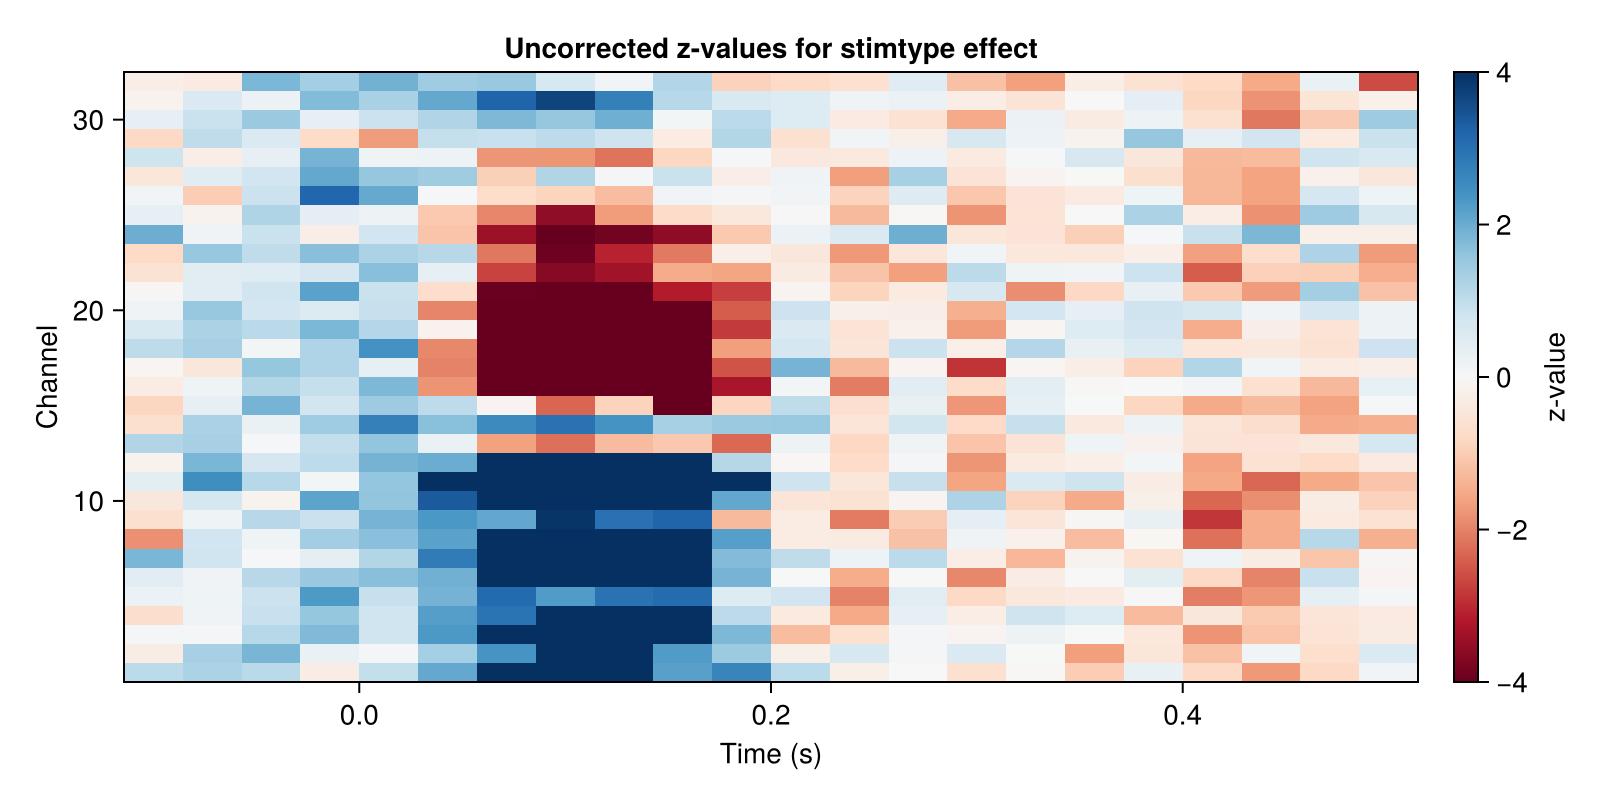

In [29]:
# Check uncorrected effects before running permutation test
# Extract coefficients for the stimtype effect
coefs = coeftable(m)

# Show available columns
println("Available columns: $(names(coefs))")

# Filter for stimtype coefficient
coef_stimtype = filter(r -> r.coefname == "stimtype: face", coefs)
println("Rows for stimtype: $(nrow(coef_stimtype))")

# Check how many unique channels and times we have
unique_channels = sort(unique(coef_stimtype.channel))
unique_times = sort(unique(coef_stimtype.time))
println("Unique channels: $(length(unique_channels))")
println("Unique times: $(length(unique_times))")

# Compute z-values from estimate/stderror, handling missing values
# Replace Nothing with NaN for computation
estimate_vec = [isnothing(x) ? NaN : Float64(x) for x in coef_stimtype.estimate]
stderror_vec = [isnothing(x) ? NaN : Float64(x) for x in coef_stimtype.stderror]
z_vec = estimate_vec ./ stderror_vec

coef_stimtype[!, :z] = z_vec

# Average across groups if there are multiple entries per channel×time
z_summary = combine(
    groupby(coef_stimtype, [:channel, :time]),
    :z => (x -> mean(filter(!isnan, x))) => :z
)
sort!(z_summary, [:channel, :time])

# Replace NaN with 0 for visualization
z_summary.z = replace(z_summary.z, NaN => 0.0)

# Reshape z-values to channels × times
n_ch_coef = length(unique_channels)
n_t_coef = length(unique_times)
z_vals = reshape(z_summary.z, n_t_coef, n_ch_coef)'  # (channels × times)

# Check for significant z-values (|z| > 2.0)
n_sig_uncorrected = sum(abs.(z_vals) .> 2.0)
max_z = maximum(abs.(z_vals))
peak_idx = argmax(abs.(z_vals))
peak_ch, peak_t = Tuple(CartesianIndices(z_vals)[peak_idx])

println("\n=== Uncorrected Effects (before permutation) ===")
println("Max |z|: $(round(max_z, digits=2))")
println("Peak location: channel $(electrode_labels[peak_ch]) at t = $(round(unique_times[peak_t], digits=3))s")
println("Samples with |z| > 2.0: $(n_sig_uncorrected) / $(length(z_vals))")
println("Samples with |z| > 1.96: $(sum(abs.(z_vals) .> 1.96)) (uncorrected p < 0.05)")

# Quick visualization of z-values
fig_z = Figure(size = (800, 400))
ax_z = Axis(fig_z[1, 1], 
    title = "Uncorrected z-values for stimtype effect",
    xlabel = "Time (s)",
    ylabel = "Channel")
hm = heatmap!(ax_z, collect(unique_times), 1:n_ch_coef, z_vals', colormap = :RdBu, colorrange = (-4, 4))
Colorbar(fig_z[1, 2], hm, label = "z-value")
fig_z

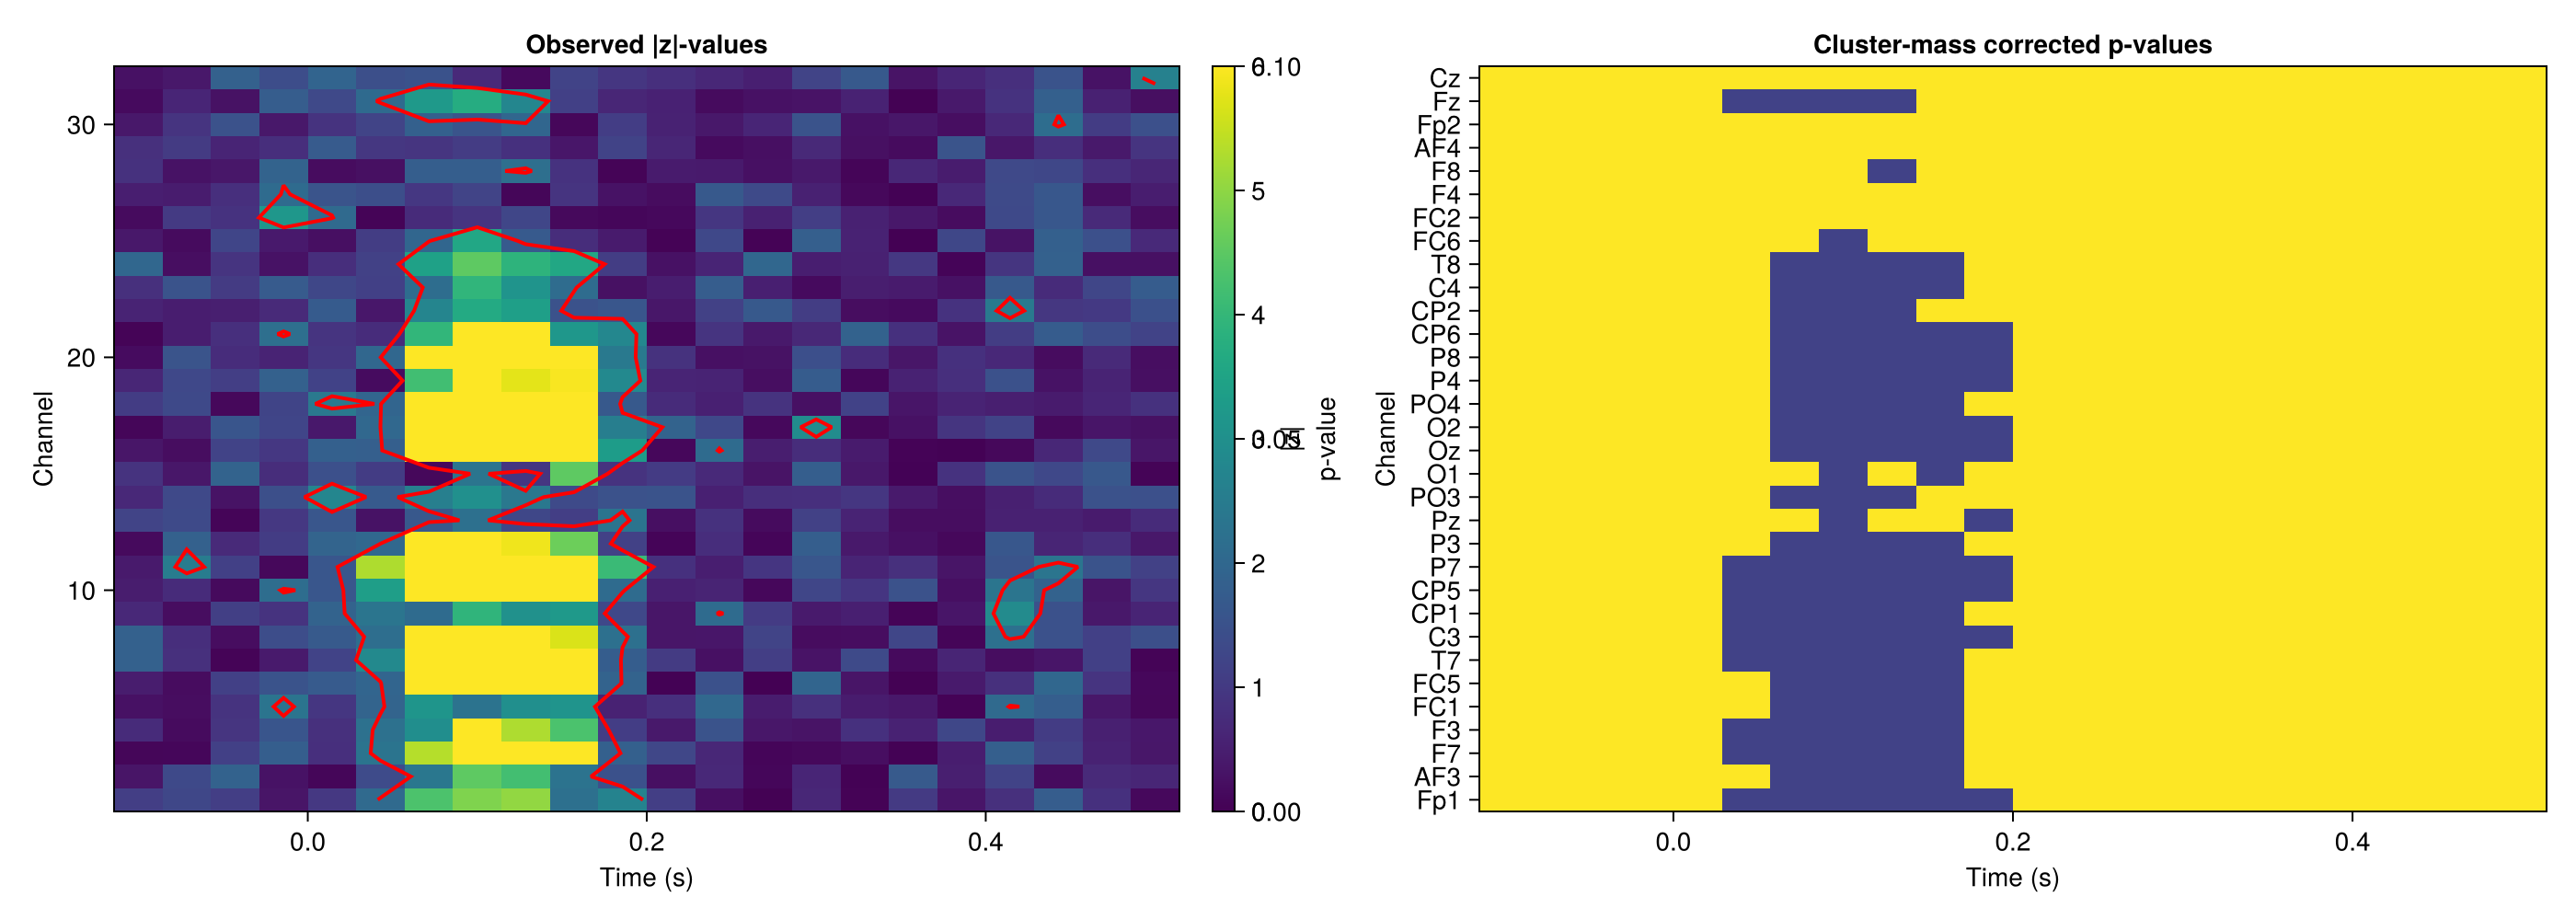

In [ ]:
# 3. Run cluster-mass permutation test
observed = z_vals;
pvals_clustermass = spatiotemporal_cluster_pvalues(MersenneTwister(1), observed, permuted, adjacency, threshold)

# 4. Visualize p-values
fig = Figure(size = (1400, 500))

ax1 = Axis(fig[1, 1], title = "Observed |z|-values", xlabel = "Time (s)", ylabel = "Channel")
hm1 = heatmap!(ax1, collect(times), 1:n_channels, abs.(z_vals)', colormap = :viridis, colorrange = (0, 6))
Colorbar(fig[1, 2], hm1, label = "|z|")
contour!(ax1, collect(times), 1:n_channels, abs.(z_vals)', levels = [2.0], color = :red, linewidth = 2)

ax2 = Axis(fig[1,3], title="Cluster-mass corrected p-values", xlabel="Time (s)", ylabel="Channel", yticks=(1:n_ch_coef, electrode_labels))
hm_p = heatmap!(ax2, collect(times), 1:n_ch_coef, pvals_clustermass', colormap=:viridis, colorrange=(0,0.1))
Colorbar(fig[1,2], hm_p, label="p-value")


fig

In [18]:
pvals_clustermass .< 0.05

UndefVarError: UndefVarError: `pvals_clustermass` not defined in `Main`
Suggestion: add an appropriate import or assignment. This global was declared but not assigned.

In [27]:
# create topoplot and butterfly plot for selected channels only
pos3d = hart.electrodes["pos"][channel_idx, :]  # 32x3 matrix for selected channels
pos2d = [Point2f(pos3d[i,1], pos3d[i,2]) for i in 1:size(pos3d,1)]  # convert to 2D points for topoplot
sig_mask = pvals_clustermass .< 0.05
cluster_data = copy(z_vals)
#cluster_data[.!sig_mask] .= 0.0  # Set non-significant to zero (or NaN)
# Ensure correct orientation: time x channels
df = DataFrame(
    :estimate => vec(cluster_data),  # no transpose, time is slow axis, channels is fast axis
    :channel => repeat(1:size(cluster_data, 1), outer = size(cluster_data, 2)),
    :time => repeat(1:size(cluster_data, 2), inner = size(cluster_data, 1))
)

Row,estimate,channel,time
,Float64,Int64,Int64
1,1.07893,1,1
2,-0.321147,2,1
3,0.083015,3,1
4,-0.711849,4,1
5,0.261592,5,1
6,0.453918,6,1
7,1.84707,7,1
8,-1.83899,8,1
9,-0.665599,9,1


Averaging across 6 time points
Any NaN in avg_topo: false


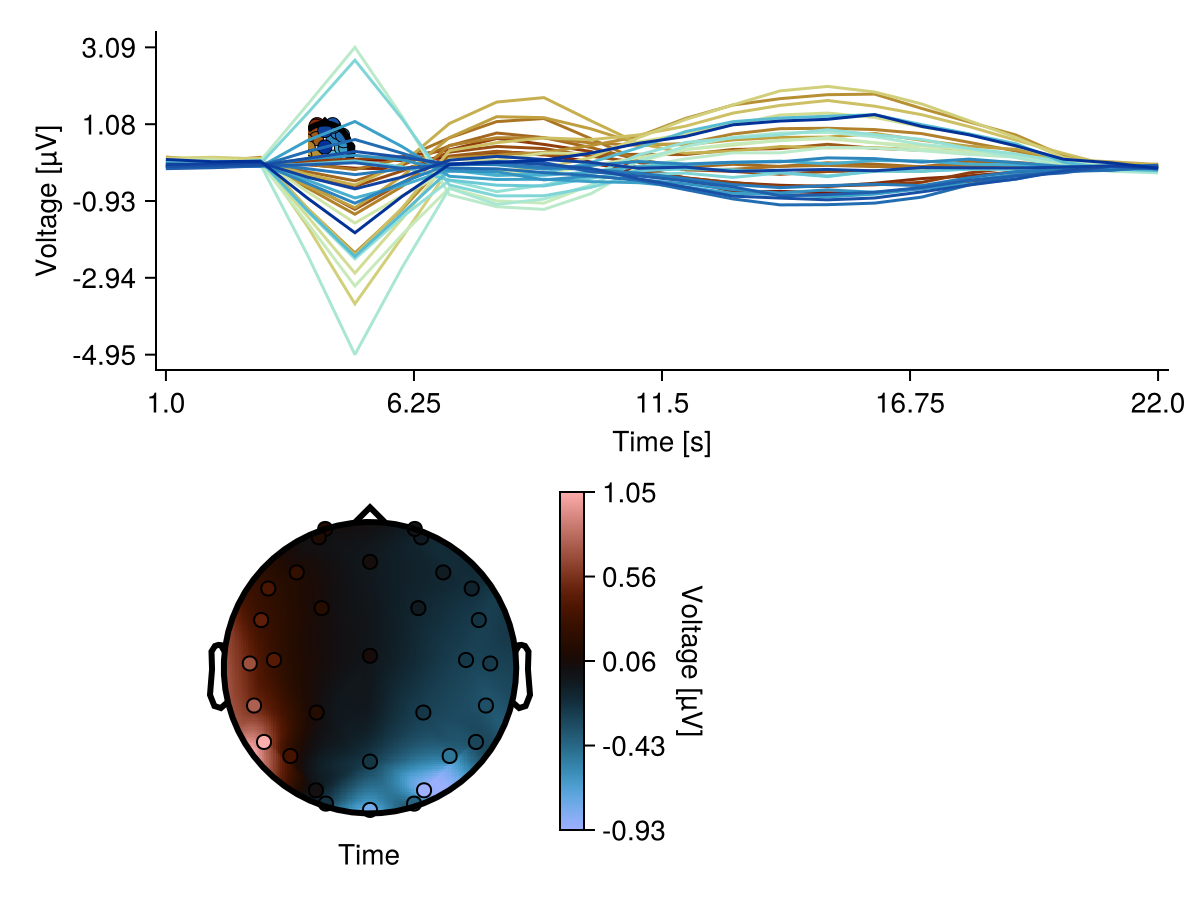

In [28]:
f = Figure()
# Average ERP across all trials for each channel and time
erp = mean(data_e; dims=3)[:,:,1]  # (channels x times)
df_erp = DataFrame(
    :amplitude => vec(erp),
    :channel => repeat(1:size(erp, 1), outer = size(erp, 2)),
    :time => repeat(1:size(erp, 2), inner = size(erp, 1))
)
plot_butterfly!(f[1, 1:2], df_erp; positions = pos2d, mapping=(; y=:amplitude))
# Find significant time points (p < 0.05)
# sig_mask is channels x times, so get time indices where any channel is significant
sig_time_bool = vec(any(sig_mask, dims=1))
unique_times = sort(unique(df_erp.time))
sig_times = unique_times[sig_time_bool]
if isempty(sig_times)
    @warn "No significant time points found; falling back to averaging across all times"
    sig_times = unique_times
end
println("Averaging across $(length(sig_times)) time points")
# Compute average topography robustly (avoid averaging over empty selection)
avg_topo = Float64[]
for ch in 1:n_channels
    sel = (df_erp.channel .== ch) .& in.(df_erp.time, Ref(sig_times))
    vals = df_erp.amplitude[sel]
    if isempty(vals)
        push!(avg_topo, NaN)
    else
        push!(avg_topo, mean(vals))
    end
end
println("Any NaN in avg_topo: ", any(isnan, avg_topo))
if any(isnan, avg_topo)
    @warn "avg_topo contains NaNs for channels: $(findall(isnan, avg_topo))"
end
# Highlight significant channels: a channel is significant if any time point is significant for it
sig_ch = [any(sig_mask[ch, :]) for ch in 1:n_channels]
# Set marker color: red for significant, gray for others
marker_colors = [is_sig ? :white : :gray for is_sig in sig_ch]
# Set marker size: larger for significant, smaller for others
marker_sizes = [is_sig ? 10 : 10 for is_sig in sig_ch]
plot_topoplot!(
    f[2, 1],
    DataFrame(:amplitude => avg_topo, :channel => 1:n_channels);
    positions = pos2d,
    mapping=(; y=:amplitude),
    visual = (; enlarge = 1, label_scatter = true, colormap = :berlin, contours = false),
    colorrange = (; colorrange = (-0.5, 0.5)),
    topo_attributes = (; label_scatter = (; color = marker_colors, markersize = marker_sizes)),
    )

f